In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/UTKFace/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg
data/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg
data/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg
data/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg
data/UTKFace/100_1_0_20170112213303693.jpg.chip.jpg
data/UTKFace/100_1_0_20170112215032192.jpg.chip.jpg
data/UTKFace/100_1_0_20170117195420803.jpg.chip.jpg
data/UTKFace/100_1_0_20170119212053665.jpg.chip.jpg
data/UTKFace/100_1_2_20170105174847679.jpg.chip.jpg
data/UTKFace/100_1_2_20170112213615815.jpg.chip.jpg
data/UTKFace/100_1_2_20170112222336458.jpg.chip.jpg
data/UTKFace/101_0_0_20170112213500903.jpg.chip.jpg
data/UTKFace/101_1_2_20170105174739309.jpg.chip.jpg
data/UTKFace/103_0_2_20170112213001988.jpg.chip.jpg
data/UTKFace/105_0_0_20170112213001988.jpg.chip.jpg
data/UTKFace/105_1_0_20170112213001988.jpg.chip.jpg
data/UTKFace/105_1_0_20170112213021902.jpg.chip.jpg
data/UTKFace/105_1_0_20170112213507183.jpg.chip.jpg
data/UTKFace/105_1_1_20170112213303693.jpg.chip.jpg
data/UTKFace

In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
# Load the Dataset
BASE_DIR = 'data/UTKFace/'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,data/UTKFace/100_0_0_20170112213500903.jpg.chi...,100,0
1,data/UTKFace/100_0_0_20170112215240346.jpg.chi...,100,0
2,data/UTKFace/100_1_0_20170110183726390.jpg.chi...,100,1
3,data/UTKFace/100_1_0_20170112213001988.jpg.chi...,100,1
4,data/UTKFace/100_1_0_20170112213303693.jpg.chi...,100,1


In [6]:
df.sample()

,image,age,gender
1660,data/UTKFace/1_0_0_20170110212654271.jpg.chip.jpg,1,0


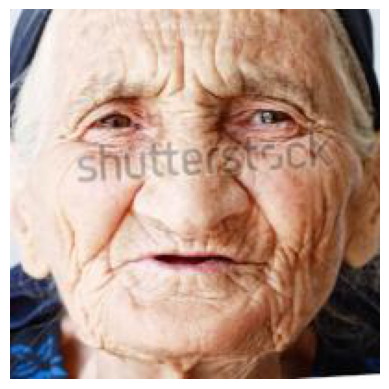

In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}
# Exploratory Data Analysis
from PIL import Image
img = Image.open(df['image'][2])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

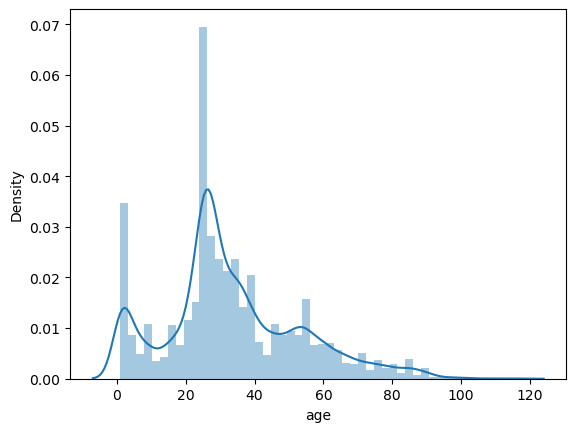

In [8]:
sns.distplot(df['age'])


<Axes: ylabel='count'>

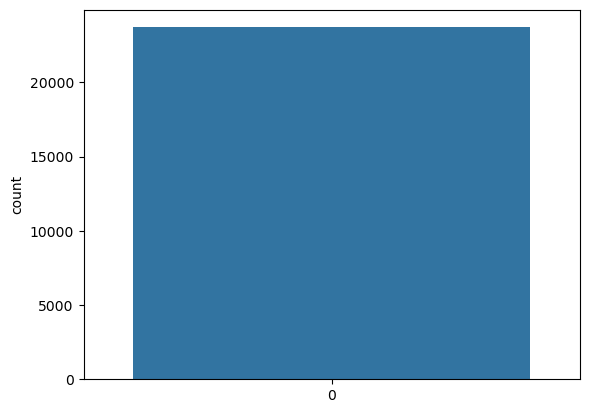

In [9]:
sns.countplot(df['gender'])


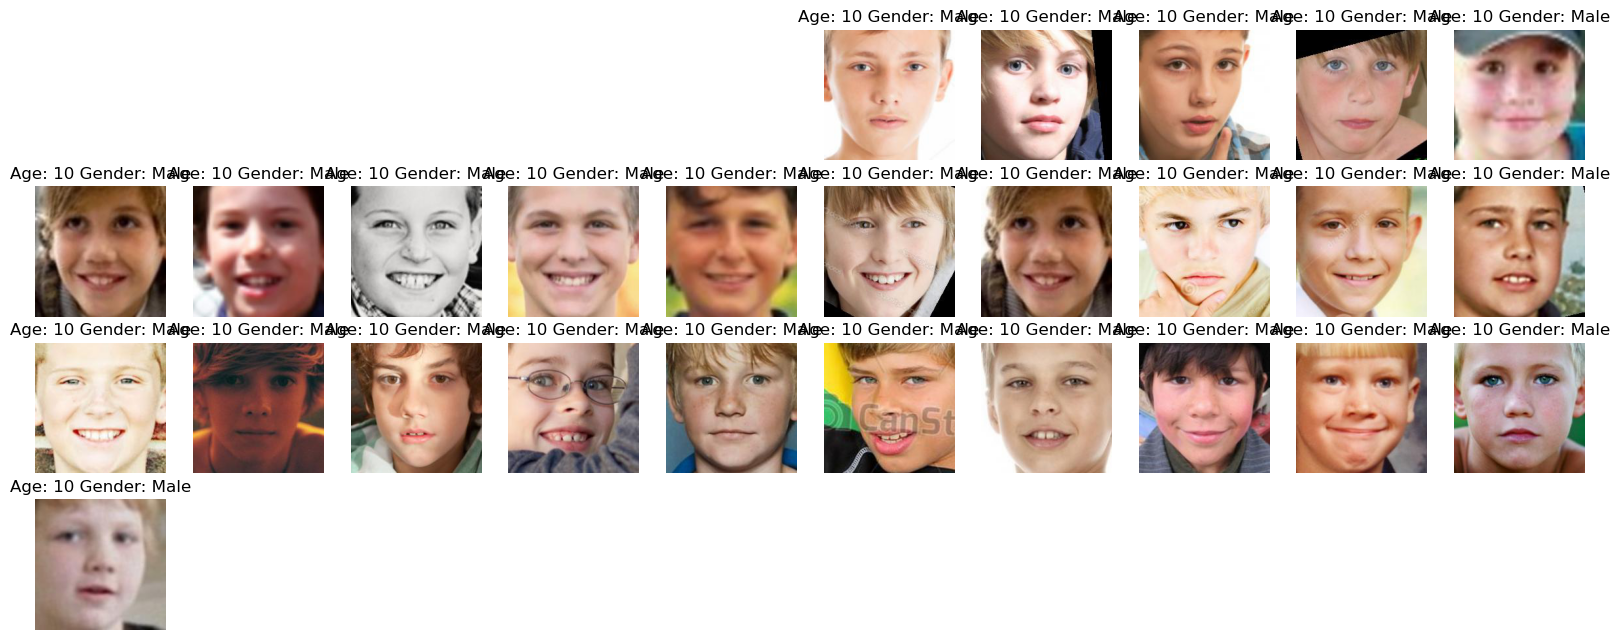

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[25:51]

for index, file, age, gender in files.itertuples():
    plt.subplot(10, 10, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])


  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape
(23708, 128, 128, 1)
# normalize the images
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (128, 128, 1)

In [14]:
# Model Building¶


In [15]:
inputs = Input((input_shape))

# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


In [16]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 347s 578ms/step - loss: 10.9929 - gender_out_loss: 0.6889 - age_out_loss: 10.3039 - gender_out_accuracy: 0.5337 - age_out_accuracy: 0.0592 - val_loss: 34.3276 - val_gender_out_loss: 0.6037 - val_age_out_loss: 33.7238 - val_gender_out_accuracy: 0.7088 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 336s 566ms/step - loss: 8.5158 - gender_out_loss: 0.4757 - age_out_loss: 8.0401 - gender_out_accuracy: 0.7723 - age_out_accuracy: 0.0561 - val_loss: 30.4521 - val_gender_out_loss: 0.4807 - val_age_out_loss: 29.9714 - val_gender_out_accuracy: 0.7640 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 333s 561ms/step - loss: 7.3539 - gender_out_loss: 0.3843 - age_out_loss: 6.9696 - gender_out_accuracy: 0.8236 - age_out_accuracy: 0.0565 - val_loss: 25.7568 - val_gender_out_loss: 0.4579 - val_age_out_loss: 25.2989 - val_gender_out_accuracy: 0.7828 - val_age_out_accur

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 460ms/step
Predicted Gender: Male Predicted Age: 12


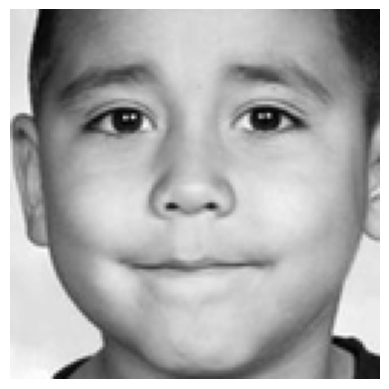

In [17]:
image_index = 102
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Male Predicted Age: 23


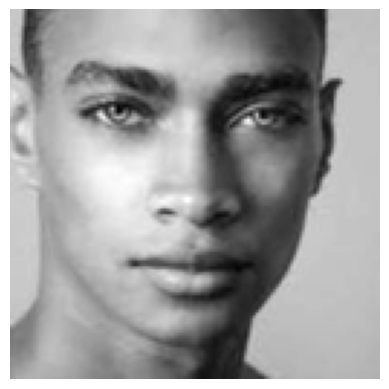

In [18]:
image_index = 3002
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Female Predicted Age: 38


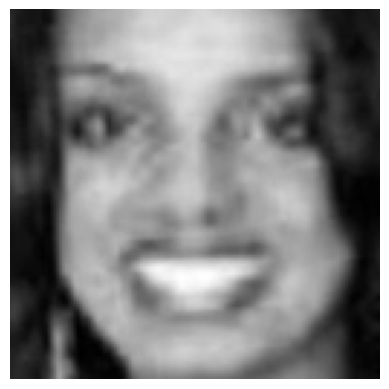

In [19]:
image_index = 10005
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');